#Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets'

/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets


In [3]:
base_dir = '/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

In [4]:
# Import all neccesary Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
import warnings 
import argparse
import seaborn as sns
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array, load_img

from keras import Input, Model
from keras.applications import MobileNet
from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

#Data Aug & Load Images

In [5]:
# Data augmentation for train dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

# Data augmentation for validation dataset (We only need to rescale)
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        validation_split = 0.5)

In [6]:
# Specify the batch size as 32 (or 64, 128, 256 e.t.c)
BATCH_SIZE = 32

# Load train dataset from the train dataset parent directory
train_set_from_dir = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

# Load the validation dataset from the validation dataset parent directory
validation_set_from_dir = validation_datagen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = "categorical",
    subset = "validation"
)

test_set_from_dir = validation_datagen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = "categorical",
    subset = "training"
)

Found 70295 images belonging to 38 classes.
Found 8777 images belonging to 38 classes.
Found 8795 images belonging to 38 classes.


In [7]:
import json
classes_dict = train_set_from_dir.class_indices
with open('/content/drive/My Drive/PLANT DISEASE RECOGNITION/class_indices.json','w') as f:
    json.dump(classes_dict, f)

#Balanced Dataset

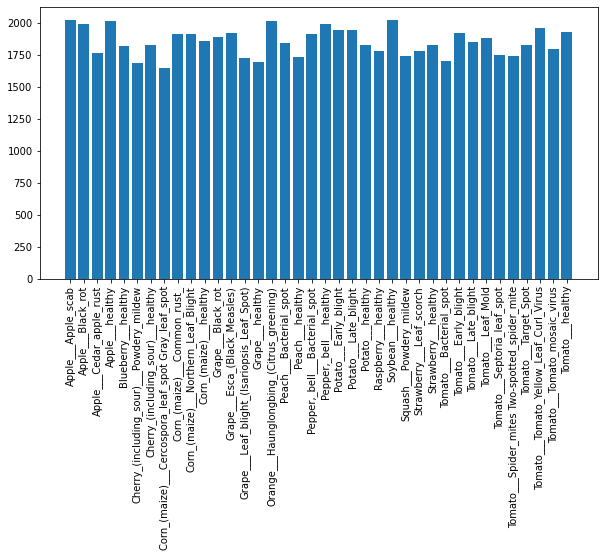

In [8]:
classes = os.listdir(train_dir)
class_count = train_set_from_dir.classes
unique, count = np.unique(class_count, return_counts=True)
class_count_dict = dict(zip(train_set_from_dir.class_indices, count))

plt.figure(figsize=(10,5))
plt.bar(class_count_dict.keys(), class_count_dict.values())
plt.xticks(rotation=90)
plt.show()

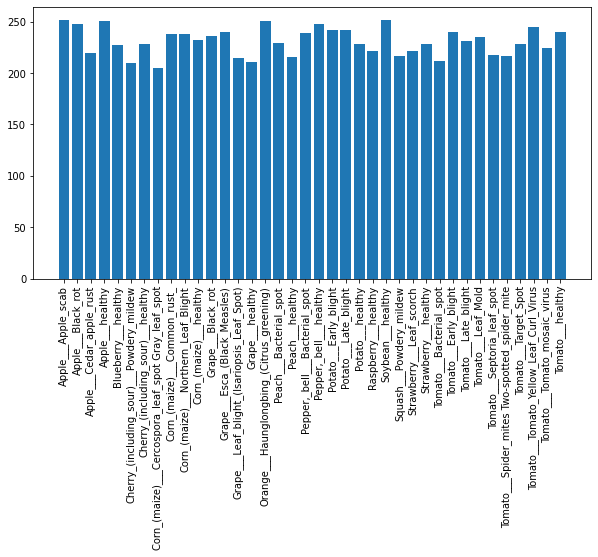

In [9]:
classes = os.listdir(valid_dir)

class_count = validation_set_from_dir.classes
unique, count = np.unique(class_count, return_counts=True)
class_count_dict = dict(zip(validation_set_from_dir.class_indices, count))

plt.figure(figsize=(10,5))
plt.bar(class_count_dict.keys(), class_count_dict.values())
plt.xticks(rotation=90)
plt.show()

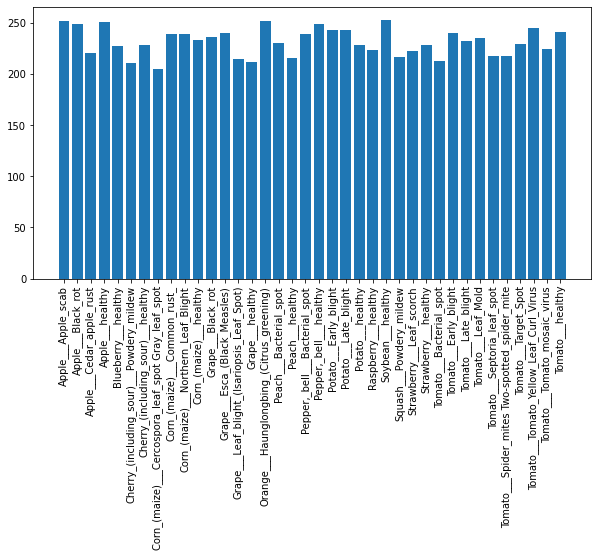

In [10]:
class_count = test_set_from_dir.classes
unique, count = np.unique(class_count, return_counts=True)
class_count_dict = dict(zip(test_set_from_dir.class_indices, count))

plt.figure(figsize=(10,5))
plt.bar(class_count_dict.keys(), class_count_dict.values())
plt.xticks(rotation=90)
plt.show()

#MobileNet

In [11]:
# This is the base model for MobileNet V2, containing different conv. layers 
base_model = MobileNet(
    #Load weights into the pre-trained MobileNet model
    weights="imagenet",
    # Input shape for the mode (height, width, number of channels)
    input_shape=(224, 224, 3),
    #Exclude the ImageNet classifier at the top of the model
    include_top=False
)  

#base_model.summary()

head_model = base_model.output
# Apply Global Average Pooling on the output
head_model = GlobalAveragePooling2D()(head_model)
# Perform Regularization by applying Dropout
head_model = Dropout(0.2)(head_model)
# We are using 38 neurons in the final dense layer because we have 38 distinct classes for prediction
# We are using softmax because it is a multi-class classification problem, to get probability distribution for each outcome.
outputs = Dense(38, activation="softmax")(head_model)
#Finally building the model with the inputs and outputs
mobilenet_model = Model(base_model.input, outputs, name='pretrained_mobilenet' )

#Freezing all layers
for layer in mobilenet_model.layers:
    layer.trainable = False

# We want to ensure that all the pre-trained weights are non-trainable, and train only the last few layers
for layer in base_model.layers[:20]:
    layer.trainable=False
for layer in base_model.layers[20:]:
    layer.trainable=True

17225924/17225924 [==============================] - 0s 0us/step


In [12]:
# Compiling the model with the optimizer and loss function
# categorical_accuracy is used as the loss function because it is a multi-class classification task
mobilenet_model.compile(optimizer = Adam(),
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy']
)

In [13]:
## Setting up callbacks for our model
# EarlyStopping to prevent overfitting, by stopping training once performance stops improving on validation set 
# ModelCheckpoint to save model checkpoints in the checkpoints folder

callbacks = [
           ModelCheckpoint('content/drive/My Drive/PLANT DISEASE RECOGNITION/checkpoints/mobilenet_plantdiseases.h5', save_best_only=True, monitor='val_acc'),
           EarlyStopping(monitor='val_loss', patience=2, verbose=1),
           ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1) 
]

# Specify Number of epochs = 10
N_EPOCHS = 10

history = mobilenet_model.fit(train_set_from_dir,
          validation_data = validation_set_from_dir,
          epochs = N_EPOCHS,
          # Use 128 random batches for training set 
          steps_per_epoch = 128, # 128 x 32 = 2**12 random samples
          # Use 64 random batches for training validation set
          validation_steps = 100, # 100 x 32 = 3200 random samples 
          callbacks = callbacks
          )

Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 0.8498 - accuracy: 0.7556

128/128 [==============================] - 1745s 14s/step - loss: 0.8498 - accuracy: 0.7556 - val_loss: 6.6355 - val_accuracy: 0.2175 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8752

128/128 [==============================] - 1479s 12s/step - loss: 0.3829 - accuracy: 0.8752 - val_loss: 1.6225 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9084

128/128 [==============================] - 1314s 10s/step - loss: 0.2906 - accuracy: 0.9084 - val_loss: 1.0676 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9265

128/128 [==============================] - 1192s 9s/step - loss: 0.2277 - accuracy: 0.9265 - val_loss: 0.3592 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9404

128/128 [==============================] - 1133s 9s/step - loss: 0.1930 - accuracy: 0.9404 - val_loss: 0.3991 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9360


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
128/128 [==============================] - 1079s 8s/step - loss: 0.1970 - accuracy: 0.9360 - val_loss: 0.6827 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 6: early stopping


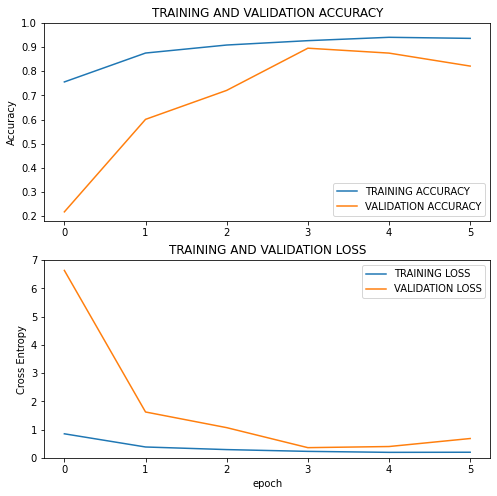

In [33]:
# Visualize the training and validation process performance 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='TRAINING ACCURACY')
plt.plot(val_acc, label='VALIDATION ACCURACY')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('TRAINING AND VALIDATION ACCURACY')

plt.subplot(2, 1, 2)
plt.plot(loss, label='TRAINING LOSS')
plt.plot(val_loss, label='VALIDATION LOSS')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,7])
plt.title('TRAINING AND VALIDATION LOSS')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 333ms/step


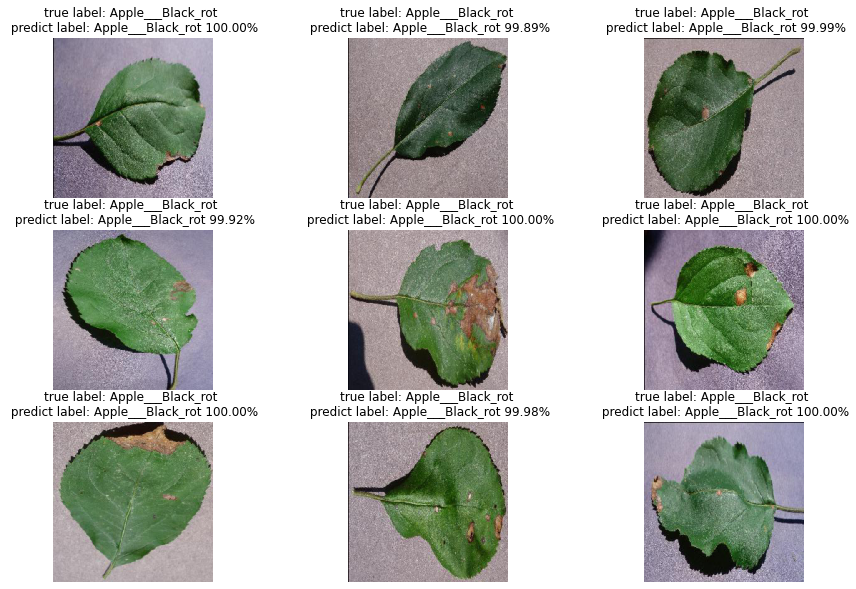

In [31]:
#mapping class
map = test_set_from_dir.class_indices
# invert mapping class
inv_class_indices = {k:v for v,k in map.items()}

# img dan true label dari test_generator
img, true_label = next(test_set_from_dir)
random_indices = np.random.choice(img.shape[0], 9, replace=False)
images = img[random_indices]
true_labels =true_label[random_indices]

# prediction
prediction = mobilenet_model.predict(images)

#visualisasi gambar
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    labels = inv_class_indices[true_labels.argmax()]
    prediction_class = np.argmax(prediction[i])
    prediction_label =inv_class_indices[prediction_class]
    probability_label = prediction[i][prediction_class] * 100
    ax.set_title(f"true label: {labels} \n predict label: {prediction_label} {probability_label:.2f}%")
    ax.axis("off")

In [16]:
y_prediction = mobilenet_model.predict(test_set_from_dir)
y_prediction = np.argmax (y_prediction, axis = 1)

275/275 [==============================] - 2368s 9s/step


In [17]:
y_label = test_set_from_dir.classes
result = confusion_matrix(y_label, y_prediction , normalize='pred')
print(result)

[[0.96078431 0.08707124 0.         ... 0.         0.         0.        ]
 [0.         0.65699208 0.         ... 0.         0.         0.        ]
 [0.         0.02110818 0.96969697 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99061033 0.0177665  0.        ]
 [0.         0.         0.         ... 0.         0.56852792 0.        ]
 [0.         0.         0.         ... 0.         0.03553299 0.9902439 ]]


<Axes: >

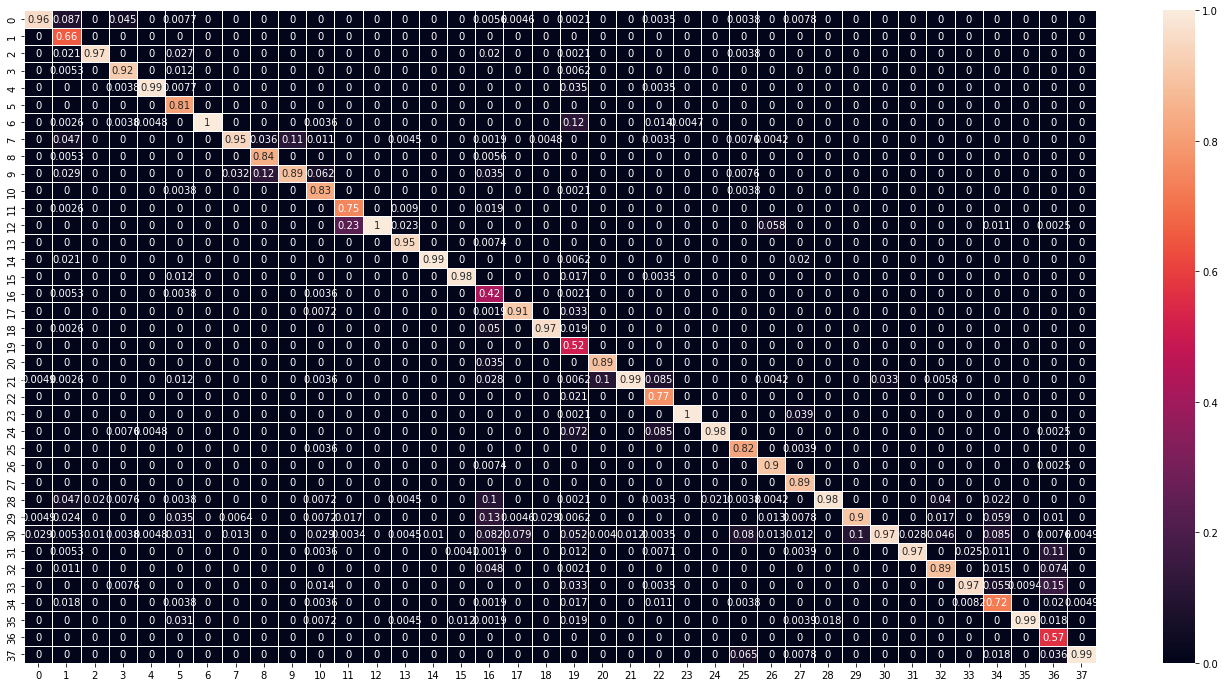

In [18]:
plt.figure(figsize = (24,12))
sns.heatmap(result, annot=True, linewidths=.5)

#Convert & Download

In [19]:
# Save model as HDF5 format
mobilenet_model.save('/content/drive/My Drive/PLANT DISEASE RECOGNITION/models/mobilenet_model.h5')

In [20]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 7.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorfl

In [21]:
%cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

/content/drive/My Drive/PLANT DISEASE RECOGNITION


In [22]:
!tensorflowjs_converter --input_format keras models/mobilenet_model.h5 tensorflowjs-model/

2023-03-28 14:56:32.917581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 14:56:32.918715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 14:56:32.918763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [23]:
!zip -r tensorflowjs-model.zip tensorflowjs-model

updating: tensorflowjs-model/ (stored 0%)
updating: tensorflowjs-model/group1-shard1of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard2of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard3of4.bin (deflated 7%)
updating: tensorflowjs-model/group1-shard4of4.bin (deflated 8%)
updating: tensorflowjs-model/model.json (deflated 94%)
